In [63]:
import pandas as pd
import keras
import os
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import random
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt 

-> Pre training word vectors (embeddings) using unlabeled data = unsupervised manner.
Model : similar to Word2Vec to learn distributed representations of words (allow to capture semantic relationships between words and synonyms in similar contexts). 
-> Supervised learning using labeled data : word embeddings previously learnt as input features for training sentiment classifier, which was a logistic regression (permits the classifier to learn word embedding to map reviews to sentiment labels). Step for fine-tuning.

### Objectif de l'article : 
 Apprendre des word vectors non pas via des méthodes non supervisées classiques (comme Word2Vec), mais en les supervisant directement via une tâche de classification de sentiment.

 Mise en place modèle :
 - 1 : Tenter approche non supervisée classique Word2Vec classique et observer résultats (moyens?)
 - 2 : Approche de l'article 
 - 3 : Trouver d'autres méthodes état de l'art et tester pour comparer ? 

 Dataset : 
 - phrases et sous-phrases extraites de critiques de film (Rotten Tomatoes)
 - chaque sous-phrase annotée avec score sentiment (fine-grained ou binaire)
 

 Approche principale : 
 Utilisation modèle récursif (RNN) structuré selon grammaire phrases
 Chaque mot représenté par vecteur
 Vecteurs combinés récursivement selon structure syntaxique (parse tree) pour produire représentation de phrase.
 Supervision à chaque noeud de l'arbre = permet ajuster vecteurs de mot selon contribution au sentiment 


A répliquer : 
- Prétraitement : tokenisation, parsing syntaxique (parser de constituants type Stanford Parser), extraction de toutes sous phrases (phrases, clauses, etc.)
- Modèle : Implémenter RNN sur arbres syntaxiques (matrice embedding, fonction de composition f(W[v1;v2] +b), classificateur au dessus représnetations des noeuds pour prédire sentiment)
- Entraînement : loss supervisée à chaque noeud (cross-entropy), propagation gradient à travers recherche recursive 

implémentation : https://github.com/stanfordnlp/treelstm

Comparer la perf avec approches modernes : LSTM, BERT, etc.

The Stanford Sentiment Treebank is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. The corpus is based on the dataset introduced by Pang and Lee (2005) and consists of 11,855 single sentences extracted from movie reviews. It was parsed with the Stanford parser and includes a total of 215,154 unique phrases from those parse trees, each annotated by 3 human judges.

Each phrase is labelled as either negative, somewhat negative, neutral, somewhat positive or positive. The corpus with all 5 labels is referred to as SST-5 or SST fine-grained. Binary classification experiments on full sentences (negative or somewhat negative vs somewhat positive or positive with neutral sentences discarded) refer to the dataset as SST-2 or SST binary.

lMD 
- 25,000 labeled reviews for training
(Highly polar — i.e., very positive or very negative)
- 25,000 labeled reviews for testing
- 50,000 unlabeled reviews for unsupervised pre-training
- Raw text and bag-of-words format included
- Binary classification only (positive vs. negative)

In [ ]:
from keras.datasets import imdb  # preprocessed version


In [ ]:
from datasets import load_dataset

sst_dataset = load_dataset("sst", "default")  # pour fine-grained
# Ou : load_dataset("sst2") pour version binaire


In [26]:
import os

# Load the data with a dictionnary (text is the movie review 
# and label is the positive or negative label)
def load_imdb_data(path, split="train"):
    data = []
    for label in ['pos', 'neg']:
        folder = os.path.join(path, split, label)
        for filename in os.listdir(folder):
            with open(os.path.join(folder, filename), encoding='utf-8') as f:
                text = f.read()
                data.append({
                    'text': text,
                    'label': 1 if label == 'pos' else 0
                })
    return data

train_data = load_imdb_data("data_movie", split="train")
test_data = load_imdb_data("data_movie", split="test")
print(f"Loaded {len(train_data)} train reviews.")
print(f"Loaded {len(test_data)} test reviews.") 

Loaded 25000 train reviews.
Loaded 25000 test reviews.


In [27]:
print(train_data[2])
print(len(train_data)+len(test_data))

{'text': 'A solid, if unremarkable film. Matthau, as Einstein, was wonderful. My favorite part, and the only thing that would make me go out of my way to see this again, was the wonderful scene with the physicists playing badmitton, I loved the sweaters and the conversation while they waited for Robbins to retrieve the birdie.', 'label': 1}
50000


## **Descriptive analysis** 

First, let us carry a descriptive analysis of the train and test set (and maybe one of the unsupervised set as well since it is used next). 
The goal is to see basic statistics (number of samples, disctribution of labels,average length text in tokens), but also textual insights (the most frequent tokens, vocabulary size, longest/shortest reviews and possible outliers), and finally some global visualizations (histogram of text length, bar plot of label distribution).

In [ ]:
# Tokenization : first approach same as in the paper, using a simple tokenizer
# based on splitting words 

import re
from collections import Counter, defaultdict

class CustomTokenizer:
    # the size of the vocabulary is 5000, and we skip the 50 most frequent tokens 
    def __init__(self, max_vocab_size=5000, skip_top=50):
        self.max_vocab_size = max_vocab_size
        self.skip_top = skip_top
        self.vocab = {}
        self.token_freqs = Counter() # for frequency
        self.special_tokens = {"<PAD>": 0, "<UNK>": 1}

    def tokenize(self, text):
        # Convert to lowercase
        text = text.lower()

        # --- Remove HTML tags (including <br>, <br />) ---
        text = re.sub(r"<br\s*/?>", " ", text)  # Replace <br> or <br /> with space
        text = re.sub(r"<[^>]+>", " ", text)   # Remove any remaining HTML tags

        # --- Remove non-alphabetical characters and extra whitespaces ---
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove non-alphanumeric characters
        text = re.sub(r"\s+", " ", text)  # collapse multiple spaces into one
        text = re.sub(r"^\s+|\s+?$", "", text)  # remove leading/trailing spaces

        # --- Punctuation handling (optional based on your requirement) ---
        text = re.sub(r'([!?.,:;()"])', r' \1 ', text)  # isolate punctuation

        return text.strip().split()

    def build_vocab(self, texts):
        # count all tokens
        for text in texts:
            tokens = self.tokenize(text)
            self.token_freqs.update(tokens)

        # build vocab
        most_common = self.token_freqs.most_common(self.skip_top + self.max_vocab_size)
        filtered_tokens = most_common[self.skip_top:]  # to skip the skip_top first tokens 

        # start vocab with special tokens for padding and unknown
        self.vocab = dict(self.special_tokens)
        for idx, (token, _) in enumerate(filtered_tokens, start=len(self.vocab)):
            self.vocab[token] = idx 

    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens]

Train size: 25000
Test size:  25000

 Label distribution train :
Label 1: 12500 samples (50.00%)
Label 0: 12500 samples (50.00%)

 Label distribution test :
Label 1: 12500 samples (50.00%)
Label 0: 12500 samples (50.00%)

 Text Length (tokens)
Train: avg=228.77, min=10, max=2450
Test:  avg=223.63, min=4, max=2186

 Vocabulary size: 5002

 30 most common tokens:
the: 650622
and: 319377
a: 319223
of: 288068
to: 266282
is: 210051
in: 183127
it: 151254
i: 145472
this: 145442
that: 135786
was: 95184
as: 90041
with: 86548
for: 86136
movie: 83509
but: 80314
film: 74463
on: 66301
not: 59500
you: 59152
are: 58157
his: 57199
have: 55020
be: 52714
he: 51781
one: 50367
its: 47883
at: 46165
all: 44493


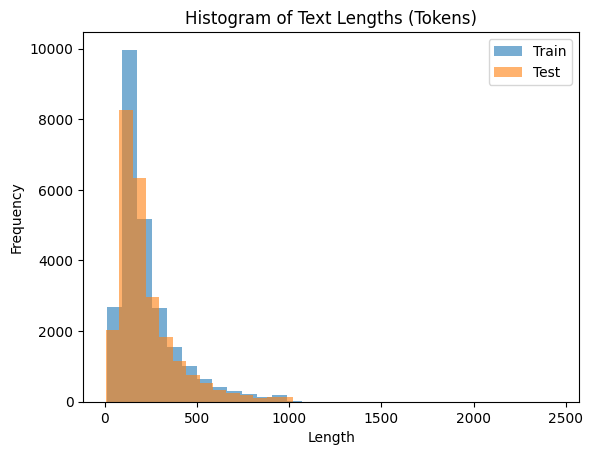

In [ ]:
train_texts = [sample['text'] for sample in train_data]
train_labels = [sample['label'] for sample in train_data]

test_texts = [sample['text'] for sample in test_data]
test_labels = [sample['label'] for sample in test_data]

print(f"Train size: {len(train_texts)}")
print(f"Test size:  {len(test_texts)}")

train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

print("\n Label distribution train :")
for label, count in train_label_counts.items():
    pct = count / len(train_labels) * 100
    print(f"Label {label}: {count} samples ({pct:.2f}%)")

print("\n Label distribution test :")
for label, count in test_label_counts.items():
    pct = count / len(test_labels) * 100
    print(f"Label {label}: {count} samples ({pct:.2f}%)")

tokenizer = CustomTokenizer()
tokenizer.build_vocab(train_texts + test_texts)

# Text lengths
train_lengths = [len(tokenizer.tokenize(text)) for text in train_texts]
test_lengths = [len(tokenizer.tokenize(text)) for text in test_texts]

print("\n Text Length (tokens)")
print(f"Train: avg={np.mean(train_lengths):.2f}, min={np.min(train_lengths)}, max={np.max(train_lengths)}")
print(f"Test:  avg={np.mean(test_lengths):.2f}, min={np.min(test_lengths)}, max={np.max(test_lengths)}")

# Vocabulary size
print(f"\n Vocabulary size: {len(tokenizer.vocab)}")

# Most common tokens
top_tokens = tokenizer.token_freqs.most_common(30)
print("\n 30 most common tokens:")
for token, freq in top_tokens:
    print(f"{token}: {freq}")

# Optional: Histogram of text lengths
plt.hist(train_lengths, bins=30, alpha=0.6, label='Train')
plt.hist(test_lengths, bins=30, alpha=0.6, label='Test')
plt.title("Histogram of Text Lengths (Tokens)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

📊 Dataset Sizes
Train size: 25000
Test size:  25000

🔢 Label Distribution (Train):


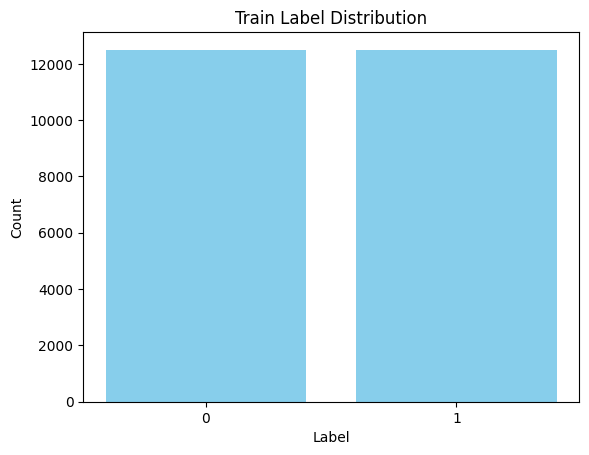

Counter({1: 12500, 0: 12500})

🔢 Label Distribution (Test):


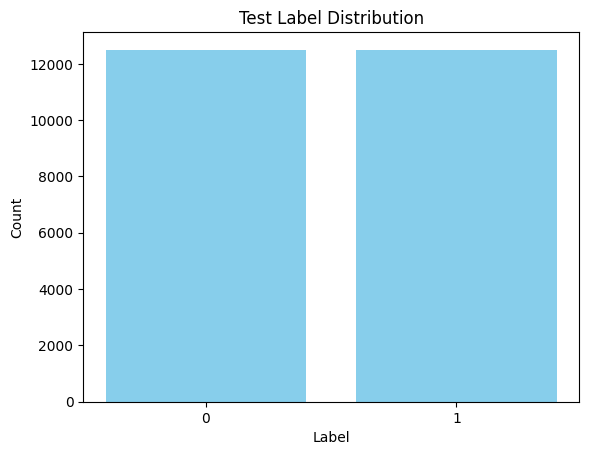

Counter({1: 12500, 0: 12500})

✏️ Text Length (tokens)
Train: avg=228.77, min=10, max=2450
Test:  avg=223.63, min=4, max=2186


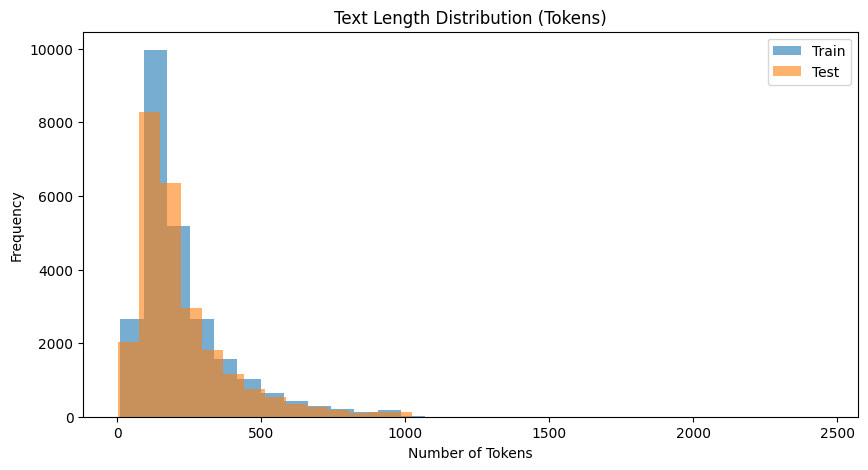


📚 Total Vocabulary Size: 5002

🔥 Top 50 Most Common Tokens:
       the : 650622
       and : 319377
         a : 319223
        of : 288068
        to : 266282
        is : 210051
        in : 183127
        it : 151254
         i : 145472
      this : 145442
      that : 135786
       was : 95184
        as : 90041
      with : 86548
       for : 86136
     movie : 83509
       but : 80314
      film : 74463
        on : 66301
       not : 59500
       you : 59152
       are : 58157
       his : 57199
      have : 55020
        be : 52714
        he : 51781
       one : 50367
       its : 47883
        at : 46165
       all : 44493
        by : 43928
        an : 42654
      they : 41340
       who : 40119
      from : 40078
      like : 38826
        so : 38551
        or : 34904
      just : 34674
       her : 34212
     about : 33843
       has : 32881
       out : 32700
        if : 31927
      some : 30639
      what : 29436
     there : 29150
      good : 28483
      more : 276

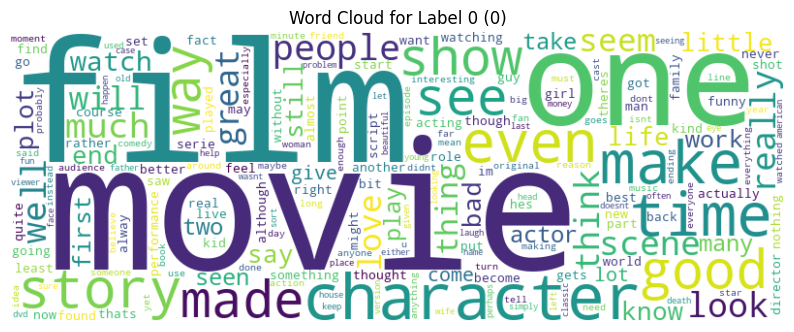

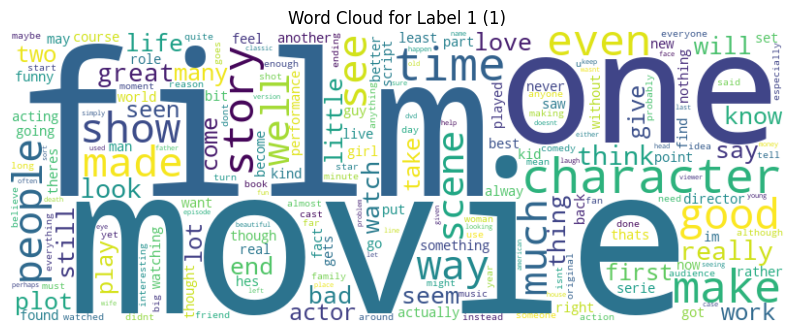

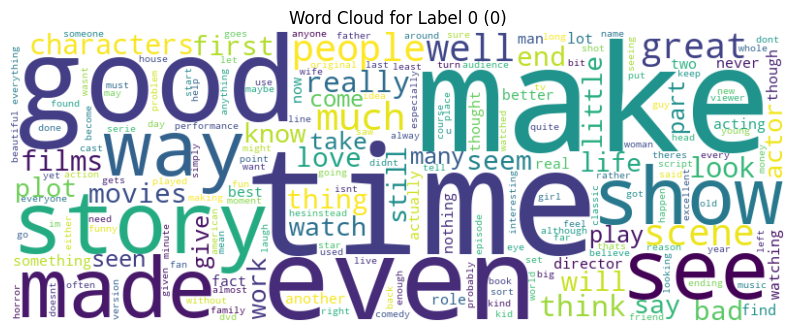

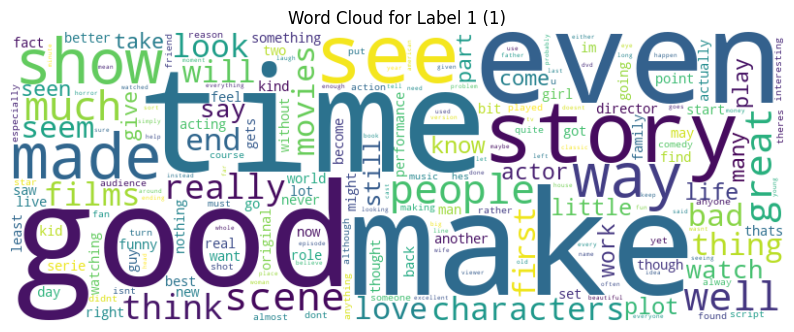

🔽 5 Shortest Reviews:

Length: 10 tokens
I wouldn't rent this one even on dollar rental night. ...

Length: 10 tokens
This movie is terrible but it has some good effects. ...

Length: 11 tokens
You'd better choose Paul Verhoeven's even if you have watched it. ...

Length: 12 tokens
Adrian Pasdar is excellent is this film. He makes a fascinating woman. ...

Length: 12 tokens
Ming The Merciless does a little Bardwork and a movie most foul! ...


🔼 5 Longest Reviews:

Length: 1544 tokens
*!!- SPOILERS - !!*<br /><br />Before I begin this, let me say that I have had both the advantages of seeing this movie on the big screen and of having seen the "Authorized Version" of this movie, remade by Stephen King, himself, in 1997.<br /><br />Both advantages made me appreciate this version of "The Shining," all the more.<br /><br />Also, let me say that I've read Mr. King's book, "The Shining" on many occasions over the years, and while I love the book and am a huge fan of his work, Stanl ...

Leng

In [97]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from wordcloud import WordCloud
import seaborn as sns

# --- Prepare Data ---
train_texts = [s['text'] for s in train_data]
train_labels = [s['label'] for s in train_data]

test_texts = [s['text'] for s in test_data]
test_labels = [s['label'] for s in test_data]

print("📊 Dataset Sizes")
print(f"Train size: {len(train_texts)}")
print(f"Test size:  {len(test_texts)}")

# --- Label Distribution ---
def plot_label_distribution(labels, title):
    counter = Counter(labels)
    labels, values = zip(*sorted(counter.items()))
    plt.bar(labels, values, color='skyblue')
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(labels)
    plt.show()
    return counter

print("\n🔢 Label Distribution (Train):")
train_dist = plot_label_distribution(train_labels, "Train Label Distribution")
print(train_dist)

print("\n🔢 Label Distribution (Test):")
test_dist = plot_label_distribution(test_labels, "Test Label Distribution")
print(test_dist)

# --- Tokenizer Setup ---
tokenizer = CustomTokenizer()
tokenizer.build_vocab(train_texts + test_texts)

# --- Text Lengths ---
train_lengths = [len(tokenizer.tokenize(text)) for text in train_texts]
test_lengths = [len(tokenizer.tokenize(text)) for text in test_texts]

print("\n✏️ Text Length (tokens)")
print(f"Train: avg={np.mean(train_lengths):.2f}, min={np.min(train_lengths)}, max={np.max(train_lengths)}")
print(f"Test:  avg={np.mean(test_lengths):.2f}, min={np.min(test_lengths)}, max={np.max(test_lengths)}")

# --- Histogram of Text Lengths ---
plt.figure(figsize=(10,5))
plt.hist(train_lengths, bins=30, alpha=0.6, label='Train')
plt.hist(test_lengths, bins=30, alpha=0.6, label='Test')
plt.title("Text Length Distribution (Tokens)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- Vocabulary Info ---
print(f"\n📚 Total Vocabulary Size: {len(tokenizer.vocab)}")
top_tokens = tokenizer.token_freqs.most_common(50)
print("\n🔥 Top 50 Most Common Tokens:")
for token, freq in top_tokens:
    print(f"{token:>10} : {freq}")

# --- Vocabulary Overlap ---
train_vocab = set(t for text in train_texts for t in tokenizer.tokenize(text))
test_vocab = set(t for text in test_texts for t in tokenizer.tokenize(text))
shared_vocab = train_vocab & test_vocab

print(f"\n🔄 Vocab Overlap: {len(shared_vocab)} shared tokens")
print(f"Train-only tokens: {len(train_vocab - test_vocab)}")
print(f"Test-only tokens:  {len(test_vocab - train_vocab)}")

# --- Word Clouds by Label ---
def plot_wordclouds_by_label(texts, labels, label_names=("0", "1"), stop_words=None):
    # Make sure stop_words is defined if passed as an argument
    if stop_words is None:
        stop_words = {"br", "the", "and", "is", "it", "to", "of"}
    
    for lbl in sorted(set(labels)):
        # Combine texts corresponding to the current label
        all_text = " ".join([texts[i] for i in range(len(labels)) if labels[i] == lbl])
        
        # Tokenize the text and filter out unwanted words
        flat_list = [word for text in texts for word in tokenizer.tokenize(text)]
        filtered_words = [word for word in flat_list if word not in stop_words]
        filtered_text = " ".join(filtered_words)

        # Generate word cloud with filtered text
        wc = WordCloud(width=800, height=300, background_color='white').generate(filtered_text)

        # Plot the word cloud
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Label {lbl} ({label_names[lbl] if isinstance(label_names, dict) else lbl})")
        plt.show()

# Example usage with train_texts and train_labels
plot_wordclouds_by_label(train_texts, train_labels)

# And if we want to add more stop words to see a bit more of the polarity 
plot_wordclouds_by_label(train_texts, train_labels,stop_words={"br", "the", "and", "is", "it", "to", "of","movie","film","one","character"})


# --- Longest/Shortest Reviews ---
train_lengths_np = np.array(train_lengths)
max_idx = train_lengths_np.argmax()
min_idx = train_lengths_np.argmin()

# Get tokenized lengths
token_lengths = [len(tokenizer.tokenize(text)) for text in train_texts]

# Pair with original text
length_text_pairs = list(zip(token_lengths, train_texts))

# Sort by length
length_text_pairs.sort()

print("🔽 5 Shortest Reviews:\n")
for length, text in length_text_pairs[:5]:
    print(f"Length: {length} tokens")
    print(text[:300], "...\n")

print("\n🔼 5 Longest Reviews:\n")
for length, text in length_text_pairs[-5:]:
    print(f"Length: {length} tokens")
    print(text[:500], "...\n")



The wordcloud is strange since there is no huge difference between the negative reviews (label 0) and the positive ones (label 1)... That might explain the poor results of the model later. 

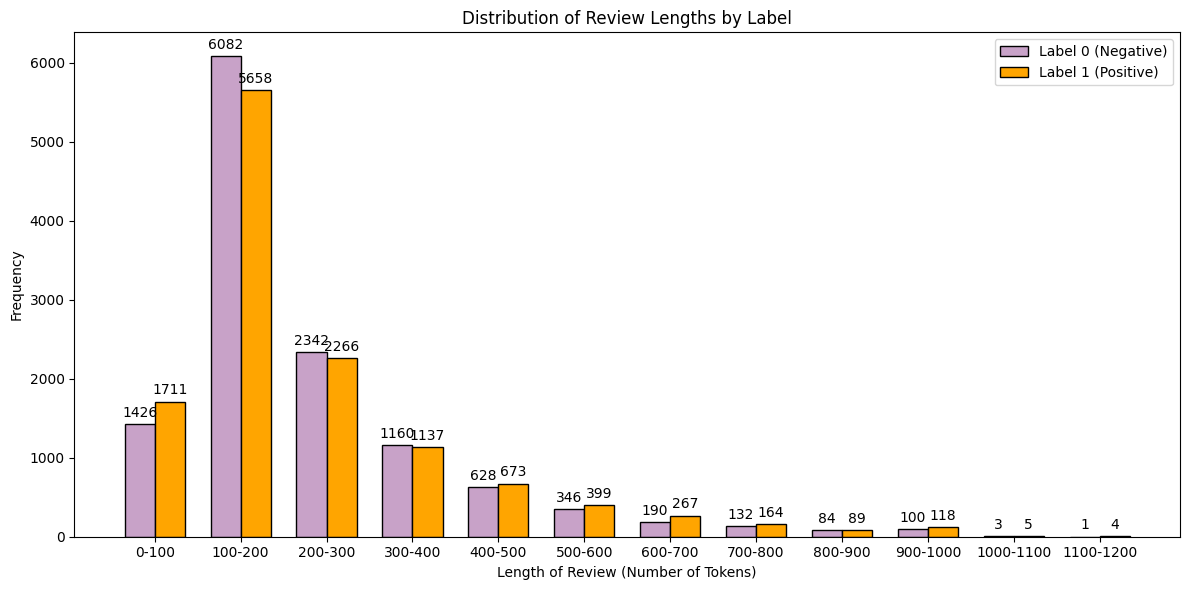

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Calculate the length of each review
review_lengths = [len(tokenizer.tokenize(text)) for text in train_texts]

# Step 2: Separate the lengths by label
lengths_label_0 = [review_lengths[i] for i in range(len(train_labels)) if train_labels[i] == 0]
lengths_label_1 = [review_lengths[i] for i in range(len(train_labels)) if train_labels[i] == 1]

# Step 3: Set the bin edges (range of lengths for the histogram)
max_length = 1200
bins = np.arange(0, max_length + 10, 100)  # bins of length 100

# Step 4: Count the frequencies of each bin
counts_0, _ = np.histogram(lengths_label_0, bins)
counts_1, _ = np.histogram(lengths_label_1, bins)

# Step 5: Set the positions of the bars on the x-axis
x = np.arange(len(bins) - 1)  # positions of the bars
width = 0.35  # the width of the bars

# Step 6: Plot side-by-side bar plot
fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, counts_0, width, label='Label 0 (Negative)', color='lilac', edgecolor='black')
rects2 = ax.bar(x + width/2, counts_1, width, label='Label 1 (Positive)', color='orange', edgecolor='black')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Frequency')
ax.set_xlabel('Length of Review (Number of Tokens)')
ax.set_title('Distribution of Review Lengths by Label')
ax.set_xticks(x)
ax.set_xticklabels([f'{bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)])  # bin ranges as labels
ax.legend()

# Function to add labels above the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Apply autolabel function to both sets of bars
autolabel(rects1)
autolabel(rects2)

# Adjust layout and display
fig.tight_layout()
plt.show()


### **Unsupervised part**

I use the unsupervised part of the train set in order to learn word embeddings. I will compare the results of known embeddings such as Word2Vec, GloVe, and FastText, Collobert, BERT (contextuel). (Faire visualisations avec T-SNE cf TP2).
Evaluer embeddings avec datasets pré-établis et annotés manuellement comme dans le TP pour justifier du choix d'embedding. 


In [28]:
# Load the unsupervised data 

def load_unsupervised_data(path):
    data = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), encoding='utf-8') as f:
            text = f.read()
            data.append(text)  # store only text since they are unlabeled
    return data

unsupervised_data = load_unsupervised_data("data_movie/train/unsup")
print(f"Loaded {len(unsupervised_data)} unsupervised reviews.")

Loaded 50000 unsupervised reviews.


### Tokenization :
 - The paper used a simple tokenizer because BERT did not exist at the time so my first approach will be to replicate this. They build a fixed dictionary of the 5.000 most frequent tokens, but ignore the 50 most frequent terms from the original full vocabulary. They do not stem or remove stop words such as punctuation '!',':-)' since they induce sentiment. 
 - Second approach : Using BERT tokenizer (or another) which has good results, because it gives contextualized embeddings (so richer), is pretrained on massive data, and has a better accuracy. 

 !!! Limit to 30 reviews per movie !!!

**First approach : building a custom tokenizer**
For the first approach, I use regex in order to make punctuation be a token because I could get things like : 
- "wonderful!!!" and if I don't split the punctuation, the token would be ["wonderful!!!"] while I would like it to be ["wonderful","!!!"]
- then I just split by spaces to get the tokens.

In [30]:
# Tokenize from training data to prevent data leakage from the test data and 
# to allow better generalization

train_texts = [sample['text'] for sample in train_data]
tokenizer = CustomTokenizer()

vocab_dict = tokenizer.build_vocab(train_texts)


print("\n--- Vocabulary Preview (first 50 words after special tokens) ---")
for i, (word, idx) in enumerate(list(tokenizer.vocab.items())[2:52], start=1):
    print(f"{idx:4} : {word}")


--- Vocabulary Preview (first 50 words after special tokens) ---
   2 : it's
   3 : ?
   4 : if
   5 : some
   6 : there
   7 : what
   8 : good
   9 : more
  10 : very
  11 : when
  12 : she
  13 : even
  14 : up
  15 : no
  16 : time
  17 : would
  18 : my
  19 : which
  20 : only
  21 : really
  22 : story
  23 : their
  24 : had
  25 : see
  26 : can
  27 : were
  28 : me
  29 : :
  30 : than
  31 : we
  32 : much
  33 : -
  34 : well
  35 : been
  36 : get
  37 : will
  38 : into
  39 : bad
  40 : people
  41 : other
  42 : because
  43 : do
  44 : also
  45 : great
  46 : him
  47 : how
  48 : first
  49 : most
  50 : don't
  51 : made


In [31]:
# Unsupervised data : tokenization  

unsup_tokenized = [tokenizer.tokenize(text) for text in unsupervised_data]

In [32]:
unsup_tokenized[0]

['a',
 'newspaperman',
 '(',
 'johnny',
 'twennies',
 ')',
 'living',
 'in',
 'the',
 "90's",
 'with',
 'a',
 'complete',
 "20's",
 'personality',
 'and',
 'lifestyle',
 '-',
 'fedora',
 ',',
 'manual',
 'typewriter',
 ',',
 'the',
 'charleston',
 ',',
 'the',
 'works',
 '.',
 "it's",
 'a',
 'great',
 'idea',
 'for',
 'a',
 'movie',
 'and',
 'it',
 "couldn't",
 'have',
 'been',
 'done',
 'better',
 '.',
 '<br',
 '/><br',
 '/>johnny',
 "doesn't",
 'miss',
 'a',
 'cliche',
 ',',
 'but',
 'never',
 'uses',
 'the',
 'same',
 'one',
 'twice',
 '.',
 "you'll",
 'find',
 'yourself',
 'anticipating',
 'his',
 'reactions',
 'to',
 'the',
 'harsher',
 "'90s",
 'world',
 'as',
 'the',
 'movie',
 'goes',
 'along',
 ',',
 "you'll",
 'often',
 'guess',
 'right',
 '-',
 'but',
 'that',
 'makes',
 'the',
 'movie',
 'just',
 'that',
 'much',
 'more',
 'fun',
 '.',
 '<br',
 '/><br',
 '/>lots',
 'of',
 'fun',
 'when',
 'johnny',
 'is',
 'called',
 'on',
 'to',
 'save',
 'the',
 'same',
 'damsel',
 'in',


Tokenization seems to work well, and we still have the information of ['don't'] and not ['do','n't'] which is questionable for sentiment analysis. 

The tokenization step is now done so we can encode the dataset to convert each text review into a sequence of integers (token ids) :

In [33]:
# Encoding the data 

encoded_train = []
for sample in train_data:
    encoded = tokenizer.encode(sample['text'])
    encoded_train.append({
        'input_ids': encoded,
        'label': sample['label']
    })

encoded_test = []
for sample in test_data:
    encoded = tokenizer.encode(sample['text'])
    encoded_test.append({
        'input_ids': encoded,
        'label': sample['label']
    })

In [9]:
print(encoded_train[1])

{'input_ids': [1100, 160, 1, 1101, 1, 747, 1511, 1, 2517, 1, 1, 1, 1, 264, 1, 1, 1, 1, 1285, 1, 1, 1, 1, 142, 1, 592, 1, 2241, 1, 1, 1, 1753, 1, 1, 1, 1, 973, 1, 1, 3273, 1, 1, 1, 1, 1, 1, 566, 1, 1, 98, 1, 1, 1, 1, 10, 34, 1931, 1, 1, 1249, 188, 1, 361, 1, 1, 1, 1, 1163, 1, 1, 4950, 1, 1, 11, 1, 1050, 38, 1, 902, 4186, 4951, 1, 1, 1, 1, 1, 1973, 2242, 1, 1, 380, 1800, 1, 1, 141, 21, 333, 1, 1, 1, 4684, 1, 539, 1, 1, 3705, 1, 1, 1, 1, 331, 1, 2009, 150, 1, 1, 1, 1, 1, 1, 131, 1, 1, 1, 1, 1, 45, 208, 1, 1, 1, 521, 1229, 1, 1, 1, 1, 705, 1, 1, 1, 1, 1, 871, 1, 1, 1, 1, 1, 1, 1, 7, 1, 2114, 1, 423, 1, 1, 1, 1, 4078, 1, 1, 1, 1, 1, 1, 1, 1, 3602, 1, 345, 1, 1, 777, 90, 34, 1, 136, 454, 2243, 1, 1, 1, 1, 1, 1, 235, 1, 2626, 1, 1, 1, 2115], 'label': 1}


There is a vocab file from the dataset but I do not use it for now since its size is way larger than 5000 (it must come from more reviews) and I will see first if my vocabulary is enough.

Now that the data is encoded, the next step is to apply some padding in order to have the same length as input for the models.

In [11]:
# Padding based on the largest sentence (token wise)

max_length = max(len(sample['input_ids']) for sample in encoded_train)
print(f"Maximum sequence length in the training data: {max_length}")


def pad_sequences(sequences, max_length, pad_token_id=0):
    padded_sequences = []
    for seq in sequences:
        padding = [pad_token_id] * (max_length - len(seq))  # Pad to the right
        padded_sequences.append(seq + padding if len(seq) < max_length else seq[:max_length])
    return padded_sequences


# Apply padding to the encoded data
padded_encoded_train = pad_sequences([sample['input_ids'] for sample in encoded_train], max_length)
padded_encoded_test = pad_sequences([sample['input_ids'] for sample in encoded_test], max_length)

padded_train_data = [{'input_ids': seq, 'label': sample['label']} for seq, sample in zip(padded_encoded_train, encoded_train)]
padded_test_data = [{'input_ids': seq, 'label': sample['label']} for seq, sample in zip(padded_encoded_test, encoded_test)]


Maximum sequence length in the training data: 2719


In [12]:
print(f"Example padded train data: {padded_train_data[0]}")
print(f"Example padded test data: {padded_test_data[0]}")

Example padded train data: {'input_ids': [1, 1, 1, 1, 171, 15, 1129, 6, 209, 1, 1, 131, 1, 858, 4297, 3472, 1, 1, 1440, 1, 793, 1, 1, 78, 870, 1, 1, 121, 122, 1, 1, 1, 1, 1, 95, 1, 1, 1, 1, 69, 1, 1, 1486, 1978, 1, 65, 1, 1558, 1, 1, 1, 1, 1, 1712, 1, 1, 1, 521, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Now that dataset imdb is loaded, we can try to tokenize the text and build a vocab

Let us now train our own embedding in a first approach, instead of using pre trained embeddings such as GLoVE, Collobert, BERT. I use Word2Vec to do so, on the unsupervised data. Then, I will use BERT which will likely result in better performance. 
We want 50-dimensional vectors (embeddings) in conformity with the article.

In [34]:
# Creation of the unsupervised embedding using Word2Vec

# I set vector_size = 50 same as the dimensional vectors of the article 
#and min_count = 5 because they filter words that appear less than 5 times 

model = Word2Vec(sentences=unsup_tokenized,vector_size=50,window=5,min_count=5,workers=4) 
model.save("word2vec_model")

In [41]:
# Test of the embedding 
word_vector = model.wv['good']
print(f"Embedding for 'good': {word_vector}")

Embedding for 'good': [ 2.084851    0.90335095  2.143251    2.066232   -0.06943671  4.4462876
 -1.3211306  -4.736172    2.7000163   0.5392463  -1.2399118   1.1521883
  2.0713096  -0.11289904  0.79157513  1.198209   -1.3867193  -3.044503
  0.32847628  0.61665833 -0.09448077 -0.18499118 -1.1790419  -1.7921611
 -6.1489043   0.94645935  5.853707   -0.6302394  -2.161383   -0.19727883
  1.2554082   3.295905   -3.650069    1.111872   -0.75216734 -1.0506707
 -0.34628892  3.2373817   0.56207126 -1.734218    0.794089   -2.3507884
 -4.6217513   0.54770666  3.6279483  -2.7243598  -0.68500006 -0.7159466
  3.0542943  -2.3259323 ]


Now, let us test the modelled embedding thanks to cosine similarity and some query words : 

In [39]:
# Cosine similarity function 

def cosine_similarity(word1, word2, model):
    # Get word vectors for word1 and word2
    vector1 = model.wv[word1]
    vector2 = model.wv[word2]
    
    # Compute cosine similarity using scipy
    return 1 - cosine(vector1, vector2)

In [61]:
# Test with a query word such as 'romantic' like in the article 

query_words = ["sadness","witty","dull","romantic"]
top_n = 5

# Most similar words
for w in query_words: 
    similar_words = model.wv.most_similar(w, topn=top_n)

    print(f"\nMost similar words to '{w}':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")



Most similar words to 'sadness':
despair: 0.8582
frustration: 0.8480
warmth: 0.8387
sorrow: 0.8336
anger: 0.8320

Most similar words to 'witty':
well-written: 0.8227
quirky: 0.8121
snappy: 0.7969
over-the-top: 0.7899
stilted: 0.7798

Most similar words to 'dull':
boring: 0.9214
predictable: 0.9208
tedious: 0.9154
pointless: 0.8836
clichéd: 0.8666

Most similar words to 'romantic':
romance: 0.7971
light-hearted: 0.7828
quirky: 0.7481
erotic: 0.7386
screwball: 0.7264


The Word2Vec trained embedding seems to be quite good at finding similar words to the query words in entry !
It captures word semantics based on co-occurrence statistics. However, it does not explicitly capture sentiment information. We will know refine embeddings to predict sentiment labels (positive or negative polarity) thanks to the labels (supervised part).

## Another word representation 

- LSA : Another approach consists in Latent Semantic Analysis (LSA). Here, is applied a SVD to a tf.idf weighted, cosine normalized count matrix. 
- LDA : Latent Dirichlet Allocation. 

LSA uses tf-idf ie a heuristic weighting scheme based on frequency and inverse document frequency so not probabilistic contrary to LDA that uses raw term counts to assume documents are mixtures of topics, and each topic a distribution of words.

L'idée est d'abord de créer une matrice de termes (tf-idf), puis de la réduire via SVD (Singular Value Decomposition) pour capturer les structures sémantiques latentes, tout en réduisant la dimensionnalité.

In [56]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Créer la matrice TF-IDF
tokenizer = CustomTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize)

X = vectorizer.fit_transform(train_texts)  # Matrice TF-IDF

#norm_X = X / np.linalg.norm(X, axis=1, keepdims=True)
# crash ici car matrice X a de grandes chances d'être sparse

# donc à la place on cherche à normaliser avc sklearn 
# Normalisation 

norm_X = normalize(X, norm='l2', axis=1)

# SVD décomposition 

n_components = 100  # (100-300 courant pour LSA)
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(norm_X)

# Extraction vecteurs de mots 
# Vocabulaire (mot -> index) tel que vu par le TfidfVectorizer
vocab = vectorizer.get_feature_names_out()
word_to_index_lsa = {word: idx for idx, word in enumerate(vocab)}

# On transpose pour avoir une représentation "mot-vecteur" (LSA)
# X_svd est document × composantes → on veut terme × composantes
term_vectors_lsa = svd.components_.T  # shape: (n_terms, n_components)


/Users/lila/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [57]:
# Test sur query words 
#from sklearn.metrics.pairwise import cosine_similarity

query_words = ["sadness", "witty", "dull", "romantic"]
top_n = 5

for query_word in query_words:
    if query_word not in word_to_index_lsa:
        print(f"'{query_word}' n'est pas dans le vocabulaire.")
        continue

    query_idx = word_to_index_lsa[query_word]
    query_vector = term_vectors_lsa[query_idx].reshape(1, -1)

    # Calculer similarité cosinus entre ce mot et tous les autres
    similarities = cosine_similarity(query_vector, term_vectors_lsa)[0]

    # Obtenir les indices des mots les plus similaires
    similar_indices = similarities.argsort()[::-1][1:top_n + 1]  # on skip le mot lui-même

    print(f"\nMost similar words to '{query_word}':")
    for idx in similar_indices:
        print(f"{vocab[idx]}: {similarities[idx]:.4f}")



Most similar words to 'sadness':
cry: 0.5771
happiness: 0.5670
hearts: 0.5416
emotions: 0.5359
experiences: 0.5096

Most similar words to 'witty':
wit: 0.5666
timing: 0.5448
comedic: 0.5169
charm: 0.5108
quirky: 0.5049

Most similar words to 'dull':
boring: 0.5983
tedious: 0.5875
pointless: 0.5506
nothing: 0.5423
there's: 0.5154

Most similar words to 'romantic':
romance: 0.7019
einstein: 0.6884
comedies: 0.6473
meg: 0.6397
light-hearted: 0.6309


#### **LDA** 
The ultimate test I wanted to implement is to try the LDA approach (Latent Dirichlet Allocation). It works almost like LSA but while LSA produces a continuous vector space, LDA produces probability distributions on topics (discreet and interpretable).

In [62]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, max_features=5000)
# X_counts = vectorizer.fit_transform(train_texts)

tokenizer = CustomTokenizer()
tokenizer.build_vocab(train_texts)

def custom_tokenizer(text):
    return tokenizer.tokenize(text)

vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=5000)
X_counts = vectorizer.fit_transform(train_texts)

vocab = vectorizer.get_feature_names_out()
word_to_index_lda = {word: idx for idx, word in enumerate(vocab)}

n_topics = 50  # nombre de topics selon l'article
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_counts)

# Shape: (n_topics, n_words)
topic_word_distrib_lda = lda.components_  # nombre de fois qu'un mot est généré par un topic

# On normalise pour obtenir une distribution de probas (somme = 1)
word_topic_vectors_lda = topic_word_distrib_lda.T / topic_word_distrib_lda.T.sum(axis=1, keepdims=True)


/Users/lila/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [60]:
# Test 
from sklearn.metrics.pairwise import cosine_similarity

query_words = ["sadness", "witty", "dull", "romantic"]
top_n = 5

for query_word in query_words:
    if query_word not in word_to_index_lda:
        print(f"'{query_word}' n'est pas dans le vocabulaire.")
        continue

    query_idx = word_to_index_lda[query_word]
    query_vector = word_topic_vectors_lda[query_idx].reshape(1, -1)

    similarities = cosine_similarity(query_vector, word_topic_vectors_lda)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]

    print(f"\nMost similar words to '{query_word}' (LDA-based):")
    for idx in similar_indices:
        print(f"{vocab[idx]}: {similarities[idx]:.4f}")



Most similar words to 'sadness' (LDA-based):
simplicity: 0.9523
experience: 0.9436
culture: 0.9424
emotions: 0.9362
joy: 0.9310

Most similar words to 'witty' (LDA-based):
wonderfully: 0.9189
perfect: 0.9118
brilliant: 0.8983
superb: 0.8934
memorable: 0.8918

Most similar words to 'dull' (LDA-based):
nowhere: 0.9029
bland: 0.8996
downright: 0.8937
unconvincing: 0.8863
premise: 0.8718

Most similar words to 'romantic' (LDA-based):
romance: 0.9075
danes: 0.8537
burns: 0.8293
won: 0.8273
walter: 0.8176


Some of the words seem strange or even unexistant, which is because the words closest are taken from the built vocabulary. 

## Document Vector Construction

Each document has a latent vector d and each word a latent vector w. In the paper, they model P(w|d) the probability of a word given the document. After training, theu use the inferred document vector d for classification (which is not a sum or average of word embeddings). For inference, they use Bayesian inference (MAP estimation) to infer these document vectors. 

2 options : 
- Replication using Bayesian unsupervised model 
- Use a modern equivalent like Doc2Vec (DM mode) : it trains document embeddings just like the paper but more easily 

In [36]:
# First approach : Bayesian inference 

def parse_feats(feats_path, num_features=None):
    matrix = []
    max_feature_id = -1  # Track the largest feature ID found
    with open(feats_path, 'r') as f:
        for line in f:
            if line.strip():  # Ensure the line is not empty
                # Split the line into terms, skip the first value (document index)
                terms = line.split()[1:]  # Skip the first term (the document ID or index)
                row = []
                for term in terms:
                    try:
                        term_id, freq = term.split(':')
                        term_id = int(term_id)
                        freq = int(freq)
                        max_feature_id = max(max_feature_id, term_id)
                        row.append((term_id, freq))
                    except ValueError:
                        # Handle invalid term
                        print(f"Skipping invalid term: {term}")
                        continue

                # If num_features is provided, ensure row length is correct
                if num_features:
                    padded_row = [0] * num_features
                    for term_id, freq in row:
                        if term_id < num_features:
                            padded_row[term_id] = freq
                    matrix.append(padded_row)
                else:
                    # If num_features is not provided, dynamically size the row
                    matrix.append([0] * (max_feature_id + 1))  # Ensure all rows are the same length
                    for term_id, freq in row:
                        matrix[-1][term_id] = freq
    return np.array(matrix)

def load_data(train_labeled_path = 'data_movie/train/labeledBow.feat',train_unsup_path = 'data_movie/train/unsupBow.feat'):
    """
    Loads both labeled and unlabeled datasets and returns them as sparse matrices.
    
    Returns:
    - labeled_matrix (scipy.sparse.lil_matrix): Sparse matrix of labeled data.
    - unlabeled_matrix (scipy.sparse.lil_matrix): Sparse matrix of unlabeled data.
    """
    labeled_feats_path = train_labeled_path 
    unlabeled_feats_path = train_unsup_path
    
    # Load labeled and unlabeled data
    labeled_matrix = parse_feats(labeled_feats_path)
    unlabeled_matrix = parse_feats(unlabeled_feats_path, num_features=labeled_matrix.shape[1])

    return labeled_matrix, unlabeled_matrix

def save_matrix(matrix, file_path):
    """
    Save a sparse matrix in a .npz file format.
    
    Args:
    - matrix (scipy.sparse): Sparse matrix to save.
    - file_path (str): Path where the matrix will be saved.
    """
    from scipy.sparse import save_npz
    save_npz(file_path, matrix)
    print(f"Saved matrix to {file_path}")

# Main function to process the data
if __name__ == "__main__":
    labeled_matrix, unlabeled_matrix = load_data()

    # Optionally save the matrices to disk
    save_matrix(labeled_matrix, 'labeled_matrix.npz')
    save_matrix(unlabeled_matrix, 'unlabeled_matrix.npz')


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (25000,) + inhomogeneous part.

In [ ]:
# Second approach : Doc2Vec 


In [20]:
# Prepare embeddings for model  

def prepare_embeddings(data, word2vec_model, max_sequence_length=100, embedding_dim=50, batch_size=1000):
    """
    Convert the tokenized sentences into word embeddings.
    """
    embeddings = []
    
    # Process in batches to avoid memory overload
    for start_idx in range(0, len(data), batch_size):
        end_idx = min(start_idx + batch_size, len(data))
        batch = data[start_idx:end_idx]
        
        batch_embeddings = []
        
        for sentence in batch:
            sentence_embedding = []
            
            for token_id in sentence['input_ids']:
                # Check if the token exists in the Word2Vec model
                if token_id in word2vec_model.wv.key_to_index:
                    sentence_embedding.append(word2vec_model.wv[token_id])
                else:
                    sentence_embedding.append(np.zeros(embedding_dim))  # OOV token (zero vector)
            
            # Ensure sequence length matches max_sequence_length
            padding_length = max_sequence_length - len(sentence_embedding)
            if padding_length > 0:
                sentence_embedding.extend([np.zeros(embedding_dim)] * padding_length)
            else:
                sentence_embedding = sentence_embedding[:max_sequence_length]
            
            batch_embeddings.append(np.array(sentence_embedding))
        
        embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)


train_embedded = prepare_embeddings(padded_train_data, model)
test_embedded = prepare_embeddings(padded_test_data, model)


LSA to try ! Based only on semantic analysis !!! and at the end compare the three approaches. Maybe change parameters in Word2Vec and see if get better ? 

In [ ]:
import numpy as np

def encode_text_with_embeddings(text, model, tokenizer):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Get the corresponding embeddings for each token
    embeddings = [model.wv[token] if token in model.wv else np.zeros(model.vector_size) for token in tokens]
    return embeddings

# Encode the training and testing data
encoded_train_data = [encode_text_with_embeddings(text, model, tokenizer) for text in train_data]
encoded_test_data = [encode_text_with_embeddings(text, model, tokenizer) for text in test_data]

from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_sequences_to_max_length(sequences, max_len):
    # Pad the sequences to a fixed length (max_len)
    return pad_sequences(sequences, maxlen=max_len, dtype="float32", padding="post", value=0)

# Choose a max length based on your data (e.g., the longest sentence)
max_len = max(len(seq) for seq in encoded_train_data)

# Pad the sequences
padded_train_data = pad_sequences_to_max_length(encoded_train_data, max_len)
padded_test_data = pad_sequences_to_max_length(encoded_test_data, max_len)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create an LSTM model for sentiment analysis
model = Sequential([
    LSTM(128, input_shape=(max_len, model.vector_size), return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on your padded data
model.fit(padded_train_data, np.array(train_labels), epochs=5, batch_size=32, validation_data=(padded_test_data, np.array(test_labels)))

In [ ]:
# Tokenization bis: 

class IMDbDataset(Dataset):
    def __init__(self, directory, vocab=None, max_vocab_size=20000, min_freq=2):
        self.samples = []  # List of (tokens, label)
        self.vocab = vocab
        self.pad_token = "<PAD>" # padding token : maked all sequences in a batch the same length so they can be stacked into tensors = add padding (so extra zeros to shorter sequences)
        self.unk_token = "<UNK>" # unknown token : handes any word that is not in the vocab (bc our vocab is max 20.000 words)

        for label, label_val in [("pos", 1), ("neg", 0)]:
            folder = os.path.join(directory, label)
            for filename in os.listdir(folder):
                with open(os.path.join(folder, filename), encoding="utf-8") as f:
                    text = f.read()
                    tokens = self.tokenize(text)
                    self.samples.append((tokens, label_val))

        if self.vocab is None:
            all_tokens = [token for tokens, _ in self.samples for token in tokens]
            freqs = Counter(all_tokens)
            most_common = [
                (word, freq) for word, freq in freqs.items() if freq >= min_freq
            ]
            most_common = sorted(most_common, key=lambda x: -x[1])[:max_vocab_size]
            self.vocab = {
                word: idx + 2 for idx, (word, _) in enumerate(most_common)
            }  # Reserve 0, 1
            self.vocab[self.pad_token] = 0
            self.vocab[self.unk_token] = 1

        self.pad_idx = self.vocab[self.pad_token]
        self.unk_idx = self.vocab[self.unk_token]

    def tokenize(self, text):
        text = text.lower()
        text = re.sub(r"<.*?>", "", text)
        return re.findall(r"\b\w+\b", text)

    def encode(self, tokens):
        return [self.vocab.get(token, self.unk_idx) for token in tokens]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tokens, label = self.samples[idx]
        encoded = self.encode(tokens)
        return torch.tensor(encoded), torch.tensor(label)

def collate_batch(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    max_len = max(lengths)
    padded = [torch.cat([seq, torch.zeros(max_len - len(seq))]) for seq in sequences]
    return torch.stack(padded).long(), torch.tensor(labels)

In [ ]:
# Step : model - average of word embeddings and logistic regression 

import torch.nn as nn

class AvgEmbeddingsClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.classifier = nn.Linear(embedding_dim, 1)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)  # (batch, seq_len, emb_dim)
        mask = (input_ids != 0).unsqueeze(-1)  # padding mask
        summed = torch.sum(embedded * mask, dim=1)
        counts = torch.sum(mask, dim=1)
        avg = summed / counts
        logits = self.classifier(avg).squeeze(1)
        return logits

In [ ]:
# Accuracy + evaluation 

def binary_accuracy(preds, labels):
    preds = torch.round(torch.sigmoid(preds))
    correct = (preds == labels).float()
    return correct.sum() / len(correct)

def evaluate_model(model, loader, device="cpu"):
    model.eval()
    total_acc = 0
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for batch in loader:
            inputs, labels = [x.to(device) for x in batch]
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            acc = binary_accuracy(outputs, labels)

            total_loss += loss.item()
            total_acc += acc.item()

    print(f" → Val Loss: {total_loss / len(loader):.4f} | Acc: {total_acc / len(loader):.4f}")



In [ ]:
# Training function 

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        for batch in train_loader:
            inputs, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            acc = binary_accuracy(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        avg_loss = epoch_loss / len(train_loader)
        avg_acc = epoch_acc / len(train_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f}")

        evaluate_model(model, val_loader, device)


In [ ]:
# Wrap up 

# Paths
train_path = "data_movie/train"
test_path = "data_movie/test"

# Load data
train_dataset = IMDbDataset(train_path)
test_dataset = IMDbDataset(test_path, vocab=train_dataset.vocab)  # use same vocab

# Split train/val
random.shuffle(train_dataset.samples)
split_idx = int(0.9 * len(train_dataset))
train_data = torch.utils.data.Subset(train_dataset, range(split_idx))
val_data = torch.utils.data.Subset(train_dataset, range(split_idx, len(train_dataset)))

# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_batch)

# Model
vocab_size = len(train_dataset.vocab)
model = AvgEmbeddingsClassifier(vocab_size, embedding_dim=100)

# Train
train_model(model, train_loader, val_loader, epochs=5, lr=1e-3, device="cuda" if torch.cuda.is_available() else "cpu")

# Evaluate 

evaluate_model(model, test_loader)


1. Preprocessing
   ⤷ Tokenize reviews
   ⤷ Build vocab

2. Word Vector Initialization
   ⤷ Random or GloVe init
   ⤷ Embeddings will be fine-tuned via supervision

3. Context Window or Full Review
   ⤷ Either train on word windows (as in the paper)
   ⤷ Or process whole review as a sequence

4. Classifier
   ⤷ Logistic regression (window-level)
   ⤷ OR CNN/LSTM over full review

5. Training
   ⤷ Cross-entropy loss
   ⤷ SGD or Adam
